LAH 탐지 (축 탐지) 변수 추가
기타 전처리 방법 및 다른 모델링 방법론 추가


In [2]:
# pip install biosppy nolds scikit-learn peakutils

In [1]:
import wfdb
import numpy as np
import pandas as pd
import glob
import os
from wfdb import rdrecord
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from scipy import signal, fft
from scipy.signal import spectrogram
from biosppy.signals.ecg import christov_segmenter, hamilton_segmenter
from nolds import sampen
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import pywt
import wfdb
from wfdb.processing import gqrs_detect
from scipy.signal import butter, filtfilt, welch, find_peaks
from scipy.stats import entropy
from multiprocessing import Pool, cpu_count
from sklearn.impute import SimpleImputer
import time
import scipy.ndimage
from scipy.stats import skew, kurtosis
from tqdm import tqdm
from math import atan2, degrees

2025-04-03 15:35:27.117331: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-03 15:35:27.118574: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-03 15:35:27.122649: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-03 15:35:27.132915: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743694527.149541     941 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743694527.15

### 함수 정의

In [3]:
!pip install EMD-signal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 24.2 MB/s eta 0:00:00


### Preprocessing

In [43]:
import numpy as np
import pandas as pd
import pywt
import scipy.ndimage
from scipy.signal import butter, filtfilt, welch, find_peaks, savgol_filter
from wfdb.processing import gqrs_detect
from tqdm import tqdm
import time
from PyEMD import EMD


# 기존 전처리 코드 유지 및 추가된 전처리 (EMD baseline removal 및 Savitzky-Golay smoothing)
def preprocess_ecg(signal_data, fs=400, use_bandpass=True, use_emd=False, use_savgol=True):
    def apply_bandpass(x):
        nyq = 0.5 * fs
        b, a = butter(4, [0.1 / nyq, 45 / nyq], btype='band')
        return filtfilt(b, a, x)

    def wavelet_denoise(signal, wavelet='db6', level=4):
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        threshold = np.median(np.abs(coeffs[-1])) / 0.6745
        coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
        return pywt.waverec(coeffs, wavelet)

    def oc_co_filter(signal, fs, k_factor):
        k_size = int(np.round(k_factor * fs))
        struct_elem = np.ones(k_size)
        opened = scipy.ndimage.grey_opening(signal, structure=struct_elem)
        closed = scipy.ndimage.grey_closing(opened, structure=struct_elem)
        return scipy.ndimage.grey_opening(closed, structure=struct_elem)

    def emd_baseline_removal(signal):
        emd = EMD()
        IMFs = emd.emd(signal)
        if IMFs.shape[0] > 1:
            return signal - IMFs[-1]  # 가장 낮은 주파수의 IMF 제거
        return signal

    def savgol_smoothing(signal, window_length=31, polyorder=3):
        return savgol_filter(signal, window_length, polyorder)

    if signal_data.ndim == 2:
        # 내부 함수가 외부 변수에 접근할 수 있게끔 위에서 정의
        def process_channel(x):
            if use_bandpass:
                x = apply_bandpass(x)
            x = wavelet_denoise(x)
            if use_emd:
                x = emd_baseline_removal(x)
            baseline = oc_co_filter(x, fs, 0.27)
            x = x - baseline
            if use_savgol:
                x = savgol_smoothing(x)
            return x
    
        # 병렬 처리로 모든 리드에 대해 전처리
        cleaned = np.array(
            Parallel(n_jobs=4)(
                delayed(process_channel)(signal_data[:, i]) for i in range(signal_data.shape[1])
            )
        ).T  # Transpose to shape (time, channel)
    
        return cleaned

    else:
        x = signal_data

        if use_bandpass:
            x = apply_bandpass(x)
        x = wavelet_denoise(x)
        
        if use_emd:
            x = emd_baseline_removal(x)

        baseline = oc_co_filter(x, fs, 0.27)
        x = x - baseline

        if use_savgol:
            x = savgol_smoothing(x)

        return x


전처리 전후 시각화해보기 (첫번째 샘플만)

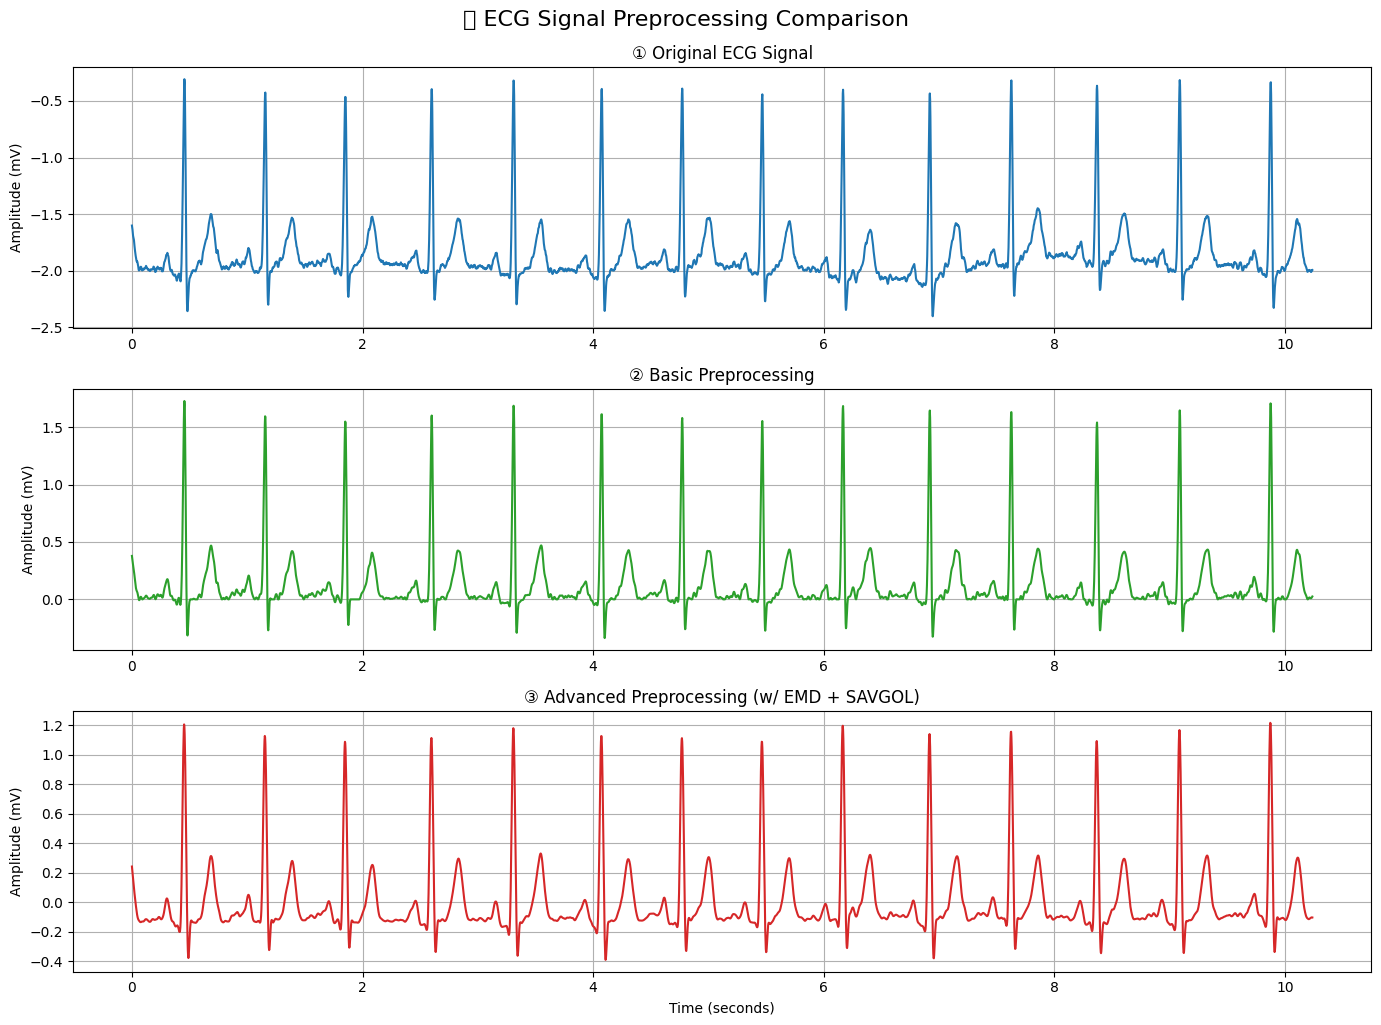

In [11]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from PyEMD import EMD

# 전처리 함수 모듈은 이미 정의되어 있다고 가정

def compare_preprocessing_versions(signal_data, fs=400, lead_index=0, use_bandpass=True, window_length=25, polyorder=3):
    """
    ECG 신호 전처리 3단계 비교 시각화 함수
    1. 원본 신호
    2. 밴드패스 + 웨이블릿 + OC_CO
    3. 2번 + EMD + SAVGOL 추가
    """

    # ✅ 1. Original
    original = signal_data[:, lead_index]

    # ✅ 2. 기본 전처리 (밴드패스 + 웨이블릿 + OC_CO)
    def basic_pipeline(x):
        if use_bandpass:
            nyq = 0.5 * fs
            b, a = butter(4, [0.1 / nyq, 45 / nyq], btype='band')
            x = filtfilt(b, a, x)
        x = wavelet_denoise(x)
        baseline = oc_co_filter(x, fs, 0.27)
        return x - baseline

    basic = basic_pipeline(original.copy())

    # ✅ 3. EMD + SAVGOL 추가 전처리
    def advanced_pipeline(x):
        x = basic_pipeline(x)
        emd = EMD()
        IMFs = emd.emd(x)
        if IMFs.shape[0] > 1:
            x = x - IMFs[-1]
        x = savgol_filter(x, window_length=window_length, polyorder=polyorder)
        return x

    advanced = advanced_pipeline(original.copy())

    # ✅ Plotting
    time_axis = np.arange(len(original)) / fs
    plt.figure(figsize=(14, 10))

    plt.subplot(3, 1, 1)
    plt.plot(time_axis, original, label='Original Signal')
    plt.title("① Original ECG Signal")
    plt.ylabel("Amplitude (mV)")
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(time_axis, basic, label='Basic Preprocessing (Bandpass + Wavelet + OC_CO)', color='tab:green')
    plt.title("② Basic Preprocessing")
    plt.ylabel("Amplitude (mV)")
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(time_axis, advanced, label='Advanced (Basic + EMD + SAVGOL)', color='tab:red')
    plt.title("③ Advanced Preprocessing (w/ EMD + SAVGOL)")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude (mV)")
    plt.grid(True)

    plt.tight_layout()
    plt.suptitle("🔍 ECG Signal Preprocessing Comparison", fontsize=16, y=1.02)
    plt.show()
# 예시: ECG 하나 뽑아서 비교
sample_signal = df_part0["p_signal"].iloc[0]  # 또는 df.sample(1)["p_signal"].values[0]
compare_preprocessing_versions(sample_signal, fs=400, lead_index=0)

## Feature extraction

In [44]:
import numpy as np
import pandas as pd
from scipy.stats import entropy, skew, kurtosis
from scipy.signal import find_peaks, welch
import pywt
from wfdb.processing import gqrs_detect
from tqdm import tqdm
import time

# R 피크를 검출하는 함수
def detect_r_peaks(ecg_signal, fs=400):
    """
    ECG 신호에서 gqrs 알고리즘을 이용하여 R 피크를 검출함.
    
    Parameters:
        ecg_signal (array): 입력 ECG 신호
        fs (int): 샘플링 주파수 (기본값: 400 Hz)
    
    Returns:
        np.array: 검출된 R 피크의 인덱스 배열 (피크가 2개 미만이면 빈 배열 반환)
    """
    r_peaks = gqrs_detect(sig=ecg_signal, fs=fs)
    return r_peaks if len(r_peaks) > 1 else np.array([])

# QRS 폭 및 QT 간격을 분석하는 함수
def analyze_qrs_qt(ecg_signal, r_peaks, fs=400):
    """
    ECG 신호에서 QRS 폭과 QT 간격을 추정함.
    
    Parameters:
        ecg_signal (array): 입력 ECG 신호
        r_peaks (array): 검출된 R 피크 인덱스
        fs (int): 샘플링 주파수 (기본값: 400 Hz)
    
    Returns:
        dict: 평균 QRS 폭과 QT 간격 (측정값이 없으면 np.nan)
    """
    if len(r_peaks) < 2:
        return {'qrs_width': np.nan, 'qt_interval': np.nan}
    qrs_widths = np.diff(r_peaks) / fs
    qt_intervals = []
    for r in r_peaks:
        if r + int(0.5 * fs) < len(ecg_signal):
            segment = ecg_signal[r:r + int(0.5 * fs)]
            peaks, _ = find_peaks(-segment)
            if len(peaks) > 0:
                qt_intervals.append((peaks[-1]) / fs)
    return {
        'qrs_width': np.nanmean(qrs_widths),
        'qt_interval': np.nanmean(qt_intervals) if qt_intervals else np.nan
    }

# 심박변이도(Heart Rate Variability, HRV) 분석 함수
def hrv_analysis(r_peaks, fs=400):
    """
    R 피크를 기반으로 HRV 관련 지표들을 계산합니다.
    
    Parameters:
        r_peaks (array): 검출된 R 피크 인덱스
        fs (int): 샘플링 주파수 (기본값: 400 Hz)
    
    Returns:
        dict: RMSSD, SDNN, SD1, SD2, SD 비율, 평균 심박수(BPM)
    """
    if len(r_peaks) < 2:
        return {
            'rmssd': np.nan,
            'sdnn': np.nan,
            'sd1': np.nan, 
            'sd2': np.nan,
            'sd_ratio': np.nan,
            'heart_rate_mean': np.nan
        }
    rr_intervals = np.diff(r_peaks) / fs
    diff_rr = np.diff(rr_intervals)
    heart_rate = 60 / rr_intervals  # BPM
    return {
        'rmssd': np.sqrt(np.mean(diff_rr**2)),
        'sdnn': np.std(rr_intervals),
        'sd1': np.std(diff_rr) / np.sqrt(2),
        'sd2': np.std(rr_intervals[:-1] + rr_intervals[1:]) / np.sqrt(2),
        'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) / (np.std(rr_intervals[:-1] + rr_intervals[1:]) / np.sqrt(2)),
        'heart_rate_mean': np.mean(heart_rate)
    }

# 주파수 분석을 통한 파워 스펙트럼 비율 계산 함수
def frequency_analysis(ecg_signal, fs=400):
    """
    Welch 방법을 이용해 ECG 신호의 파워 스펙트럼을 계산하고,
    각 주파수 대역(ULF, VLF, LF, HF)의 에너지 비율을 구합니다.
    
    Parameters:
        ecg_signal (array): 입력 ECG 신호
        fs (int): 샘플링 주파수 (기본값: 400 Hz)
    
    Returns:
        dict: 각 주파수 대역의 에너지 비율
    """
    freqs, power = welch(ecg_signal, fs=fs, nperseg=256)
    bands = {'ulf': (0.003, 0.04), 'vlf': (0.04, 0.15), 'lf': (0.04, 0.15), 'hf': (0.15, 0.4)}
    total_energy = np.sum(power)
    band_energy = {band: np.sum(power[(freqs >= low) & (freqs < high)]) 
                   for band, (low, high) in bands.items()}
    return {k: v / total_energy if total_energy > 0 else 0 for k, v in band_energy.items()}

# 웨이블릿 변환 기반 피처 추출 함수
def extract_wavelet_features(ecg_signal, wavelet='db4', level=4):
    """
    웨이블릿 변환을 통해 ECG 신호의 통계적 피처(평균, 표준편차, 에너지, 에너지 비율, 엔트로피)를 추출합니다.
    
    Parameters:
        ecg_signal (array): 입력 ECG 신호
        wavelet (str): 사용 웨이블릿 종류 (기본값: 'db4')
        level (int): 분해 레벨 (기본값: 4)
    
    Returns:
        dict: 웨이블릿 레벨별 통계 피처와 평균 엔트로피
    """
    coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)
    features = {}
    total_energy = sum(np.sum(np.square(c)) for c in coeffs)
    entropies = [entropy(np.abs(c) / np.sum(np.abs(c)), base=2) if np.sum(np.abs(c)) > 0 else 0 for c in coeffs]
    for i, c in enumerate(coeffs):
        abs_c = np.abs(c)
        features[f'wavelet_L{i}_mean'] = np.mean(abs_c)
        features[f'wavelet_L{i}_std'] = np.std(c)
        features[f'wavelet_L{i}_energy'] = np.sum(np.square(c))
        features[f'wavelet_L{i}_energy_ratio'] = np.sum(np.square(c)) / total_energy if total_energy > 0 else 0
    features['wavelet_entropy'] = np.mean(entropies)
    return features

# Sample Entropy 계산 함수
def sample_entropy(signal, m=2, r=0.2):
    """
    시계열 데이터의 샘플 엔트로피를 계산합니다.
    
    Parameters:
        signal (array): 입력 신호
        m (int): 임베딩 차원 (기본값: 2)
        r (float): 허용 오차 비율 (기본값: 0.2, 표준편차의 비율)
    
    Returns:
        float: 샘플 엔트로피 값
    """
    N = len(signal)
    r *= np.std(signal)
    def _phi(m):
        x = np.array([signal[i:i + m] for i in range(N - m)])
        C = np.sum(np.max(np.abs(x[:, None] - x[None, :]), axis=2) < r, axis=0) - 1
        return np.sum(C) / (N - m)
    return -np.log(_phi(m + 1) / _phi(m)) if _phi(m) != 0 else np.nan

# Lempel-Ziv 복잡도 계산 함수
def lempel_ziv_complexity(signal):
    """
    이진 시퀀스로 변환한 후 Lempel-Ziv 복잡도를 계산합니다.
    
    Parameters:
        signal (array): 입력 신호
    
    Returns:
        int: Lempel-Ziv 복잡도 값
    """
    binary_seq = ''.join(['1' if s > 0 else '0' for s in signal])
    i, k, l = 0, 1, 1
    c = 1
    n = len(binary_seq)
    while True:
        if i + k == n:
            c += 1
            break
        if binary_seq[i:i + k] == binary_seq[l:l + k]:
            k += 1
        else:
            i += 1
            if i == l:
                c += 1
                l += k
                k = 1
                i = 0
        if l + k > n:
            c += 1
            break
    return c

# PR/RR/QRS/QT 비율 계산 함수
def temporal_morphology_ratios(features_dict):
    """
    추출된 피처들을 바탕으로 QRS/QT 및 PR/RR 비율을 계산합니다.
    
    Parameters:
        features_dict (dict): 피처 딕셔너리 (qt_interval, qrs_width, heart_rate_mean 등 포함)
    
    Returns:
        dict: 계산된 비율 값들
    """
    ratios = {}
    if 'qt_interval' in features_dict and 'qrs_width' in features_dict:
        qt = features_dict['qt_interval']
        qrs = features_dict['qrs_width']
        if qt and qt != 0:
            ratios['qrs_qt_ratio'] = qrs / qt
    if 'heart_rate_mean' in features_dict and features_dict['heart_rate_mean'] != 0 and 'qt_interval' in features_dict:
        qt = features_dict['qt_interval']
        rr = 60.0 / features_dict['heart_rate_mean']
        pr = qt * 0.25  # 임의 설정 (샘플에 따라 다름), 실제 PR 계산 추가 가능
        ratios['pr_rr_ratio'] = pr / rr
    return ratios

# 신호 복잡도 및 형태학 피처를 추가하는 함수
def add_morphological_complexity_features(signal, extracted_dict):
    """
    입력 신호의 샘플 엔트로피와 Lempel-Ziv 복잡도를 계산하여 피처 딕셔너리에 추가합니다.
    
    Parameters:
        signal (array): 입력 신호
        extracted_dict (dict): 기존 피처 딕셔너리
    
    Returns:
        dict: 복잡도 피처가 추가된 딕셔너리
    """
    extracted_dict['sample_entropy'] = sample_entropy(signal)
    extracted_dict['lz_complexity'] = lempel_ziv_complexity(signal)
    return extracted_dict

# # 확장된 피처를 추출하는 함수 (preprocess_ecg 함수는 별도 정의되어 있어야 함)
# def extract_features(ecg_signal, fs=400):
#     """
#     ECG 신호에서 QRS, HRV, 주파수, 웨이블릿 및 복잡도 피처 등 확장된 피처들을 추출합니다.
#     (preprocess_ecg 함수가 미리 정의되어 있다고 가정)
    
#     Parameters:
#         ecg_signal (array): 입력 ECG 신호
#         fs (int): 샘플링 주파수 (기본값: 400 Hz)
    
#     Returns:
#         dict: 추출된 모든 피처들의 딕셔너리
#     """
#     filtered = preprocess_ecg(ecg_signal, fs)
#     r_peaks = detect_r_peaks(filtered, fs)
    
#     basic = {
#         **analyze_qrs_qt(filtered, r_peaks, fs),
#         **hrv_analysis(r_peaks, fs),
#         **frequency_analysis(filtered, fs),
#         **extract_wavelet_features(filtered),
#         'skewness': skew(filtered),
#         'kurtosis': kurtosis(filtered)
#     }
#     ratios = temporal_morphology_ratios(basic)
#     complexity = add_morphological_complexity_features(filtered, {})
    
#     return {**basic, **ratios, **complexity}


def extract_features(ecg_signal, fs=400):
    """
    빠른 버전의 ECG 피처 추출 함수 (느린 항목 제거)
    """
    filtered = preprocess_ecg(ecg_signal, fs)
    r_peaks = detect_r_peaks(filtered, fs)

    # 핵심 피처만 유지
    basic = {
        **analyze_qrs_qt(filtered, r_peaks, fs),
        **hrv_analysis(r_peaks, fs),
        **frequency_analysis(filtered, fs),
        **extract_wavelet_features(filtered, level=3),  # 성능 저하 없이 속도 개선
        'skewness': skew(filtered),
        'kurtosis': kurtosis(filtered)
    }

    # 복잡도 피처 제거
    # complexity = add_morphological_complexity_features(filtered, {})

    # 시간-형태 비율은 매우 가볍기 때문에 유지 가능
    ratios = temporal_morphology_ratios(basic)

    return {**basic, **ratios}




# DataFrame에 저장된 ECG 신호에 대해 확장 피처를 추출하는 함수
def process_with_progress(df, num_samples=None, fs=400, lead_index=0, include_metadata=True):
    """
    DataFrame 내 ECG 신호에 대해 확장 피처를 추출하며 진행 상황을 출력합니다.
    선택적으로 데이터 샘플링 및 메타데이터 포함 여부를 지정할 수 있습니다.
    
    Parameters:
        df (DataFrame): ECG 데이터를 포함하는 DataFrame (컬럼 'p_signal' 등 포함)
        num_samples (int, optional): 처리할 샘플 수 (None이면 전체 처리)
        fs (int): 샘플링 주파수 (기본값: 400 Hz)
        lead_index (int): 사용할 lead 인덱스 (기본값: 0)
        include_metadata (bool): 메타데이터 포함 여부 (기본값: True)
    
    Returns:
        DataFrame: 추출된 피처와 (선택적으로) 메타데이터가 병합된 DataFrame
    """
    start_time = time.time()
    df_sample = df.sample(n=num_samples, random_state=42).reset_index(drop=True) if num_samples else df.copy().reset_index(drop=True)
    all_rows = []

    for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc="확장 특징 추출 중", dynamic_ncols=True):
        try:
            ecg_signal = row["p_signal"][:, lead_index]
            features = extract_features(ecg_signal, fs=fs)
            features = {f"{lead_index}_{k}": v for k, v in features.items()}
            if include_metadata:
                metadata = row.drop("p_signal").to_dict()
                metadata["Age_gap"] = metadata.get("Age", np.nan) - metadata.get("nn_predicted_age", np.nan)
                merged = {**features, **metadata}
            else:
                merged = {**features, "exam_id": row["exam_id"]}
            all_rows.append(merged)
        except Exception as e:
            print(f"오류 발생: {e} (샘플 {idx} 건너뜀)")
            continue

    df_features = pd.DataFrame(all_rows)
    df_features.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_features = df_features.dropna(axis=1, thresh=0.6 * len(df_features))
    print(f"\n총 {len(df_features)}개 샘플 피처 추출 완료! (소요시간: {time.time() - start_time:.2f}초)")
    return df_features

In [ ]:

# QRS 벡터 방향 계산

from scipy.signal import find_peaks

def detect_lah_angle(ecg_signal_2d, fs=400):
    """
    Lead I, Lead aVF 기반 평균 QRS angle 추정 (도 단위)
    ecg_signal_2d: (time, leads) 형태의 2D ECG 신호
    """
    try:
        lead_I = ecg_signal_2d[:, 0]
        lead_aVF = ecg_signal_2d[:, 5]  # aVF 보통 6번째 리드

        r_peaks = detect_r_peaks(lead_I, fs)
        qrs_vectors = []

        for r in r_peaks:
            if r + int(0.08 * fs) < len(lead_I):  # 80ms QRS window
                x = lead_I[r:r + int(0.08 * fs)].mean()
                y = lead_aVF[r:r + int(0.08 * fs)].mean()
                qrs_vectors.append((x, y))

        if not qrs_vectors:
            return {"qrs_angle_deg": np.nan}

        x_mean = np.mean([vec[0] for vec in qrs_vectors])
        y_mean = np.mean([vec[1] for vec in qrs_vectors])

        angle_rad = np.arctan2(y_mean, x_mean)
        angle_deg = np.degrees(angle_rad)
        return {"qrs_angle_deg": angle_deg}
    except Exception as e:
        print(f"⚠️ detect_lah_angle error: {e}")
        return {"qrs_angle_deg": np.nan}

def process_with_progress_lah_angle(df, num_samples=None, fs=400):
    """
    ECG에서 QRS angle 추출 (리드 I, aVF 사용)
    """
    start_time = time.time()
    if num_samples is None:
        df_sample = df.copy().reset_index(drop=True)
    else:
        df_sample = df.sample(n=num_samples, random_state=42).reset_index(drop=True)

    all_rows = []
    for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc="🔸 QRS angle 추출", dynamic_ncols=True):
        try:
            signal = row["p_signal"]
            features = detect_lah_angle(signal, fs=fs)
            features["exam_id"] = row["exam_id"]  # 병합용
            all_rows.append(features)
        except Exception as e:
            print(f"⚠️ 오류: {e} (샘플 {idx} 건너뜀)")
            continue

    df_angle = pd.DataFrame(all_rows)
    print(f"\n✅ LAH QRS angle 추출 완료! (총 {len(df_angle)}개)")
    return df_angle



## code15 데이터 처리

피처 추출 (lead1: index0)

In [3]:
df_part0 = pd.read_pickle("/workspace/my_data/code15_part0.pkl")
df_part1 = pd.read_pickle("/workspace/my_data/code15_part1.pkl")

In [45]:
df0 = process_with_progress(df_part0, fs=400, lead_index=0, include_metadata=True)

/tmp/ipykernel_941/897953255.py:82: RuntimeWarning: invalid value encountered in scalar divide                                                                | 552/19901 [00:17<09:37, 33.48it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) / (np.std(rr_intervals[:-1] + rr_intervals[1:]) / np.sqrt(2)),
/tmp/ipykernel_941/897953255.py:82: RuntimeWarning: invalid value encountered in scalar divide                                                                | 604/19901 [00:18<10:00, 32.11it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) / (np.std(rr_intervals[:-1] + rr_intervals[1:]) / np.sqrt(2)),
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.                                                  | 608/19901 [00:19<09:46, 32.89it/s]
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.typ

오류 발생: cannot convert float NaN to integer (샘플 9172 건너뜀)


/tmp/ipykernel_941/897953255.py:82: RuntimeWarning: invalid value encountered in scalar divide                                                               | 9282/19901 [04:40<05:30, 32.17it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) / (np.std(rr_intervals[:-1] + rr_intervals[1:]) / np.sqrt(2)),
/tmp/ipykernel_941/897953255.py:82: RuntimeWarning: divide by zero encountered in scalar divide                                                              | 9294/19901 [04:40<05:44, 30.77it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) / (np.std(rr_intervals[:-1] + rr_intervals[1:]) / np.sqrt(2)),
/tmp/ipykernel_941/897953255.py:82: RuntimeWarning: invalid value encountered in scalar divide                                                               | 9362/19901 [04:42<05:09, 34.10it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) / (np.std(rr_intervals[:-1] + rr_intervals[1:]) / np.sqrt(2)),
/tmp/ipykernel_941/897953255.py:82: RuntimeWarning: invalid value encountered in scalar div

오류 발생: cannot convert float NaN to integer (샘플 13186 건너뜀)


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.█▌                                              | 13248/19901 [06:40<03:26, 32.26it/s]
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_941/897953255.py:82: RuntimeWarning: invalid value encounte

오류 발생: cannot convert float NaN to integer (샘플 19102 건너뜀)


/tmp/ipykernel_941/897953255.py:82: RuntimeWarning: invalid value encountered in scalar divide████████████████████████████████████████████████████████▉     | 19177/19901 [09:39<00:20, 34.67it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) / (np.std(rr_intervals[:-1] + rr_intervals[1:]) / np.sqrt(2)),
/tmp/ipykernel_941/897953255.py:82: RuntimeWarning: invalid value encountered in scalar divide█████████████████████████████████████████████████████████     | 19189/19901 [09:39<00:20, 34.12it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) / (np.std(rr_intervals[:-1] + rr_intervals[1:]) / np.sqrt(2)),
/tmp/ipykernel_941/897953255.py:82: RuntimeWarning: invalid value encountered in scalar divide█████████████████████████████████████████████████████████     | 19201/19901 [09:39<00:20, 34.24it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) / (np.std(rr_intervals[:-1] + rr_intervals[1:]) / np.sqrt(2)),
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mea


총 19898개 샘플 피처 추출 완료! (소요시간: 601.86초)


In [47]:
df0.columns

Index(['0_qrs_width', '0_qt_interval', '0_rmssd', '0_sdnn', '0_sd1', '0_sd2',
       '0_sd_ratio', '0_heart_rate_mean', '0_ulf', '0_vlf', '0_lf', '0_hf',
       '0_wavelet_L0_mean', '0_wavelet_L0_std', '0_wavelet_L0_energy',
       '0_wavelet_L0_energy_ratio', '0_wavelet_L1_mean', '0_wavelet_L1_std',
       '0_wavelet_L1_energy', '0_wavelet_L1_energy_ratio', '0_wavelet_L2_mean',
       '0_wavelet_L2_std', '0_wavelet_L2_energy', '0_wavelet_L2_energy_ratio',
       '0_wavelet_L3_mean', '0_wavelet_L3_std', '0_wavelet_L3_energy',
       '0_wavelet_L3_energy_ratio', '0_wavelet_entropy', '0_skewness',
       '0_kurtosis', '0_qrs_qt_ratio', '0_pr_rr_ratio', 'exam_id', 'Age',
       'Chagas_label', 'is_male', 'nn_predicted_age', 'RBBB', 'LBBB', 'AF',
       'normal_ecg', 'Age_gap'],
      dtype='object')

In [ ]:
df1 = process_with_progress(df_part1, fs=400, lead_index=0, include_metadata=True)

In [13]:
# 새로 QRS 각도만 추출
df_angle = process_with_progress_lah_angle(df_part0)

# exam_id 기준으로 병합
df = pd.merge(df0, df_angle, on="exam_id", how="inner")

🔸 QRS angle 추출: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19901/19901 [07:30<00:00, 44.19it/s]


✅ LAH QRS angle 추출 완료! (총 19901개)


In [10]:
# 위아래로 이어 붙이기 (row 방향 concat)
df = pd.concat([df_part0, df_part1], axis=0).reset_index(drop=True)

# 결과 확인
print(f"✅ 전체 샘플 수: {len(df)}")
df

✅ 전체 샘플 수: 39790


,qrs_width,qt_interval,rmssd,sdnn,sd1,sd2,sd_ratio,heart_rate_mean,ulf,vlf,...,kurtosis,exam_id,Age,Chagas_label,is_male,nn_predicted_age,RBBB,LBBB,AF,normal_ecg
0,0.719375,0.477692,0.041100,0.024498,0.029040,0.020699,1.402959,83.500678,0.0,0.0,...,14.548812,1398216,35,0,0,50.454483,0,0,0,0
1,1.089286,0.477500,0.182908,0.115540,0.128080,0.111161,1.152211,55.713488,0.0,0.0,...,20.951377,620215,19,0,0,28.217638,0,0,0,1
2,0.650000,0.482222,0.008073,0.007071,0.005428,0.005901,0.919866,92.318824,0.0,0.0,...,24.106136,712938,59,0,0,67.447525,0,0,0,0
3,0.936944,0.483750,0.023402,0.022104,0.016511,0.028401,0.581356,64.073834,0.0,0.0,...,32.168562,1504935,60,0,0,64.676575,0,0,0,1
4,0.767813,0.481944,0.023299,0.027427,0.015110,0.030081,0.502321,78.240330,0.0,0.0,...,27.153980,1229800,58,0,0,66.523140,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39785,0.871786,0.476875,0.017078,0.023403,0.010541,0.030185,0.349215,68.873037,0.0,0.0,...,25.888368,1549519,40,0,1,66.570370,0,0,0,1
39786,0.803750,0.479643,0.009152,0.011792,0.004555,0.013647,0.333780,74.666152,0.0,0.0,...,13.357309,4208809,36,0,1,31.170006,0,0,0,0
39787,0.644038,0.471786,0.006124,0.009534,0.004290,0.012947,0.331342,93.182459,0.0,0.0,...,21.381233,475767,61,0,0,61.709570,0,0,0,1
39788,1.028571,0.480313,0.029368,0.022315,0.020353,0.025062,0.812084,58.360745,0.0,0.0,...,23.311692,1524075,40,0,0,57.973840,0,0,0,1


### 7번 리드 특징 추출 (index=6)

In [42]:
df_part0 = pd.read_pickle("/workspace/my_data/code15_part0.pkl")
df_part1 = pd.read_pickle("/workspace/my_data/code15_part1.pkl")

In [ ]:
df0 = process_with_progress(df_part0, lead_index=6, use_bandpass=False, include_metadata=False)
df1 = process_with_progress(df_part1, lead_index=6, use_bandpass=False, include_metadata=False)

🔹 특징 추출 중:   1%|▊                                                                                                         | 157/19901 [00:05<08:32, 38.50it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 149 건너뜀)


/tmp/ipykernel_12047/2324083429.py:83: RuntimeWarning: invalid value encountered in scalar divide                          | 603/19901 [00:18<09:39, 33.31it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
🔹 특징 추출 중:   3%|███▎                                                                                                      | 616/19901 [00:18<08:51, 36.25it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 609 건너뜀)


/tmp/ipykernel_12047/2324083429.py:83: RuntimeWarning: divide by zero encountered in scalar divide                        | 1122/19901 [00:33<09:34, 32.67it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
🔹 특징 추출 중:  11%|███████████▎                                                                                             | 2137/19901 [01:02<08:29, 34.90it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 2132 건너뜀)


🔹 특징 추출 중:  22%|███████████████████████▏                                                                                 | 4399/19901 [02:08<06:54, 37.38it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 4391 건너뜀)


🔹 특징 추출 중:  40%|██████████████████████████████████████████▎                                                              | 8015/19901 [03:54<05:27, 36.30it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 8011 건너뜀)


/opt/conda/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.s]
  warnings.warn(
🔹 특징 추출 중:  46%|████████████████████████████████████████████████▍                                                        | 9176/19901 [04:27<04:54, 36.46it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 9172 건너뜀)


🔹 특징 추출 중:  55%|█████████████████████████████████████████████████████████▏                                              | 10951/19901 [05:19<04:00, 37.26it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 10944 건너뜀)


🔹 특징 추출 중:  66%|████████████████████████████████████████████████████████████████████▎                                   | 13064/19901 [06:20<03:13, 35.37it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 13059 건너뜀)


🔹 특징 추출 중:  67%|██████████████████████████████████████████████████████████████████████                                  | 13395/19901 [06:30<02:50, 38.09it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 13389 건너뜀)


🔹 특징 추출 중:  68%|███████████████████████████████████████████████████████████████████████▏                                | 13617/19901 [06:36<02:57, 35.43it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 13613 건너뜀)


🔹 특징 추출 중:  74%|████████████████████████████████████████████████████████████████████████████▊                           | 14690/19901 [07:07<02:21, 36.74it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 14684 건너뜀)


🔹 특징 추출 중:  77%|████████████████████████████████████████████████████████████████████████████████▎                       | 15366/19901 [07:26<02:02, 37.15it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 15358 건너뜀)


🔹 특징 추출 중:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████▊     | 18898/19901 [09:09<00:27, 36.49it/s]

In [45]:
# 위아래로 이어 붙이기 (row 방향 concat)
df_2 = pd.concat([df0, df1], axis=0).reset_index(drop=True)

# 결과 확인
print(f"✅ 전체 샘플 수: {len(df)}")
df_2

✅ 전체 샘플 수: 39790


,8_qrs_width,8_qt_interval,8_rmssd,8_sdnn,8_sd1,8_sd2,8_sd_ratio,8_heart_rate_mean,8_ulf,8_vlf,...,8_wavelet_L3_std,8_wavelet_L3_energy,8_wavelet_L3_energy_ratio,8_wavelet_L4_mean,8_wavelet_L4_std,8_wavelet_L4_energy,8_wavelet_L4_energy_ratio,8_wavelet_entropy,8_skewness,8_kurtosis
0,0.635556,0.480278,0.195712,0.156306,0.138230,0.171450,0.806242,102.499649,0.0,0.0,...,0.120357,14.912287,0.000195,0.005405,0.044822,4.121964,0.000054,5.505130,6.663389,43.766349
1,1.089286,0.485000,0.182332,0.115370,0.127669,0.111222,1.147881,55.712239,0.0,0.0,...,0.020796,0.445054,0.001005,0.000977,0.001786,0.006547,0.000015,7.034992,3.934684,23.565052
2,0.646944,0.482500,0.028926,0.018811,0.020309,0.017274,1.175696,92.821502,0.0,0.0,...,0.069242,3.538943,0.004054,0.004844,0.023315,0.799062,0.000915,7.303936,-0.150523,8.587176
3,0.936667,0.489500,0.022448,0.022142,0.015835,0.028864,0.548583,64.092926,0.0,0.0,...,0.021923,0.494638,0.001811,0.001168,0.002309,0.010932,0.000040,7.326212,-2.631069,17.971118
4,0.767500,0.485000,0.023261,0.027300,0.015081,0.030449,0.495266,78.271717,0.0,0.0,...,0.081877,4.947695,0.006567,0.004161,0.016083,0.380269,0.000505,6.843054,-3.692055,21.432842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39758,0.871786,0.471250,0.016266,0.023365,0.009878,0.030116,0.327995,68.872923,0.0,0.0,...,0.126042,11.726993,0.004283,0.004965,0.025058,0.923105,0.000337,6.772780,-2.185543,10.767117
39759,0.755714,0.484063,0.131929,0.119147,0.083527,0.094717,0.881865,82.398546,0.0,0.0,...,0.054044,2.156095,0.003166,0.003739,0.009465,0.131700,0.000193,7.082364,1.558940,1.636486
39760,0.644231,0.474286,0.032275,0.021380,0.022791,0.018845,1.209431,93.234937,0.0,0.0,...,0.021192,0.462133,0.002195,0.001176,0.001975,0.007997,0.000038,7.645770,-0.814461,6.886968
39761,1.028571,0.481563,0.029368,0.022315,0.020353,0.025062,0.812084,58.360745,0.0,0.0,...,0.023281,0.557733,0.000782,0.001272,0.002029,0.008443,0.000012,7.465280,-2.745569,15.762037


## 모델링 1 > catboost

In [39]:
# pip install --upgrade xgboost

In [129]:
# pip install imbalanced-learn

In [14]:
import numpy as np
import pandas as pd
import time
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from catboost import CatBoostClassifier
from xgboost import XGBClassifier, callback

# X, y 나누기
def preprocess_dataframe(df):
    """데이터프레임에서 NaN 처리 및 feature, target 분리"""
    df = df.dropna(axis=1, thresh=0.5 * len(df))  # NaN이 50% 이상인 컬럼 제거

    imputer = SimpleImputer(strategy="median")
    X = imputer.fit_transform(df.drop(columns=["Chagas_label"]))
    y = df["Chagas_label"].values  # 타겟 변수 분리

    return X, y

# 데이터 스플릿 (8:2)
def split_data(X, y, test_size=0.2):
    return train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

# CatBoost parameter 최적화 함수
def objective_catboost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'depth': trial.suggest_int('depth', 2, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'loss_function': 'Logloss',
        'eval_metric': 'F1',
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=False)

    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

    
# ✅ Catboost 학습
def train_catboost(X_train, y_train, X_test, y_test, **params):
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)
    return model


# ✅ 모델 평가
def evaluate_model(model, X_test, y_test, model_name):
    """Confusion Matrix 및 성능 지표 출력"""
    y_pred = model.predict(X_test)
    
    print(f"\n✅ {model_name} 모델 평가")
    print("🔹 Accuracy:", accuracy_score(y_test, y_pred))
    print("🔹 F1 Score:", f1_score(y_test, y_pred))
    print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))

    # ✅ Confusion Matrix 시각화
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    
# ✅ Feature Importance 시각화
def plot_feature_importance(model, feature_names):
    """Feature Importance 시각화"""
    feature_importances = model.get_feature_importance()
    sorted_idx = np.argsort(feature_importances)[::-1]  # 중요도가 높은 순 정렬

    plt.figure(figsize=(10, 5))
    sns.barplot(x=feature_importances[sorted_idx[:10]], y=np.array(feature_names)[sorted_idx[:10]], palette="viridis")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Name")
    plt.title("Top 10 Feature Importances")
    plt.show()

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
df.drop(columns=['exam_id'], inplace=True)

In [16]:
df.columns

Index(['0_qrs_width', '0_qt_interval', '0_rmssd', '0_sdnn', '0_sd1', '0_sd2',
       '0_sd_ratio', '0_heart_rate_mean', '0_ulf', '0_vlf', '0_lf', '0_hf',
       '0_wavelet_L0_mean', '0_wavelet_L0_std', '0_wavelet_L0_energy',
       '0_wavelet_L0_energy_ratio', '0_wavelet_L1_mean', '0_wavelet_L1_std',
       '0_wavelet_L1_energy', '0_wavelet_L1_energy_ratio', '0_wavelet_L2_mean',
       '0_wavelet_L2_std', '0_wavelet_L2_energy', '0_wavelet_L2_energy_ratio',
       '0_wavelet_L3_mean', '0_wavelet_L3_std', '0_wavelet_L3_energy',
       '0_wavelet_L3_energy_ratio', '0_wavelet_L4_mean', '0_wavelet_L4_std',
       '0_wavelet_L4_energy', '0_wavelet_L4_energy_ratio', '0_wavelet_entropy',
       '0_skewness', '0_kurtosis', 'Age', 'Chagas_label', 'is_male',
       'nn_predicted_age', 'RBBB', 'LBBB', 'AF', 'normal_ecg', 'Age_gap',
       'qrs_angle_deg'],
      dtype='object')

데이터 스케일링 및 스플릿

In [32]:
from sklearn.model_selection import train_test_split

# 함수 실행
X, y = preprocess_dataframe(df)  # 데이터 분석 전에 전처리

# 스케일링
X_numeric = df[['0_qrs_width', '0_qt_interval', '0_rmssd', '0_sdnn', '0_sd1', '0_sd2',
       '0_sd_ratio', '0_heart_rate_mean', '0_ulf', '0_vlf', '0_lf', '0_hf',
       '0_wavelet_L0_mean', '0_wavelet_L0_std', '0_wavelet_L0_energy',
       '0_wavelet_L0_energy_ratio', '0_wavelet_L1_mean', '0_wavelet_L1_std',
       '0_wavelet_L1_energy', '0_wavelet_L1_energy_ratio', '0_wavelet_L2_mean',
       '0_wavelet_L2_std', '0_wavelet_L2_energy', '0_wavelet_L2_energy_ratio',
       '0_wavelet_L3_mean', '0_wavelet_L3_std', '0_wavelet_L3_energy',
       '0_wavelet_L3_energy_ratio', '0_wavelet_L4_mean', '0_wavelet_L4_std',
       '0_wavelet_L4_energy', '0_wavelet_L4_energy_ratio', '0_wavelet_entropy',
       '0_skewness', '0_kurtosis','qrs_angle_deg']]
X_categorical = df[['Age', 'Chagas_label', 'is_male',
       'nn_predicted_age', 'RBBB', 'LBBB', 'AF', 'normal_ecg', 'Age_gap']]  # 그대로 사용

# Scaling
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# 다시 합치기
X = np.hstack([X_numeric_scaled, X_categorical])

# 스플릿
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # 클래스 불균형 고려
)

### Catboost

In [18]:
from sklearn.model_selection import train_test_split

# 함수 실행
X, y = preprocess_dataframe(df)

# 스플릿
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # 클래스 불균형 고려
)

In [19]:
study_cat = optuna.create_study(direction="maximize")
study_cat.optimize(objective_catboost, n_trials=10)

best_params_cat = study_cat.best_params
print("최적 CatBoost 하이퍼파라미터:", best_params_cat)

[I 2025-03-28 07:54:57,407] A new study created in memory with name: no-name-3db780fe-4d12-4090-95db-7b0d3fbe9c82
/tmp/ipykernel_28/273896562.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_28/273896562.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
/tmp/ipykernel_28/273896562.py:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_unif

최적 CatBoost 하이퍼파라미터: {'n_estimators': 1971, 'depth': 5, 'learning_rate': 0.16472918783772889, 'l2_leaf_reg': 0.00723844528838194, 'bagging_temperature': 0.7037977112355487}


In [22]:
# 최적 CatBoost 하이퍼파라미터: {'n_estimators': 1971, 'depth': 5, 'learning_rate': 0.16472918783772889, 'l2_leaf_reg': 0.00723844528838194, 'bagging_temperature': 0.7037977112355487}

catboost_model = CatBoostClassifier(
                    **best_params_cat,
                    class_weights = [1, 10],
                    verbose=0)
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)

# ✅ 3. CatBoost 모델 평가
y_pred_cat = catboost_model.predict(X_test)
accuracy_cat = accuracy_score(y_test, y_pred_cat)
f1_cat = f1_score(y_test, y_pred_cat)

print(f"CatBoost Accuracy: {accuracy_cat:.4f}")
print(f"CatBoost F1 Score: {f1_cat:.4f}")

## 가중치 줄 경우 (1,5)
# CatBoost Accuracy: 0.9763
# CatBoost F1 Score: 0.2286

CatBoost Accuracy: 0.9683
CatBoost F1 Score: 0.1600


In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

# ✅ 교차 검증 설정
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []
acc_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_train_cv, X_val_cv = X[train_idx], X[val_idx]
    y_train_cv, y_val_cv = y[train_idx], y[val_idx]

    model_cv = CatBoostClassifier(
        **best_params_cat,
        class_weights=[1, 6],
        verbose=0
    )

    model_cv.fit(X_train_cv, y_train_cv, eval_set=(X_val_cv, y_val_cv), early_stopping_rounds=50, verbose=0)

    preds = model_cv.predict(X_val_cv)
    
    acc = accuracy_score(y_val_cv, preds)
    f1 = f1_score(y_val_cv, preds)

    acc_scores.append(acc)
    f1_scores.append(f1)

    print(f"Fold {fold+1} - Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

print("\n교차 검증 결과 (5-Fold)")
print(f"Average Accuracy: {np.mean(acc_scores):.4f}")
print(f"Average F1 Score: {np.mean(f1_scores):.4f}")

Fold 1 - Accuracy: 0.9746, F1 Score: 0.2628
Fold 2 - Accuracy: 0.9736, F1 Score: 0.1732
Fold 3 - Accuracy: 0.9744, F1 Score: 0.1905
Fold 4 - Accuracy: 0.9736, F1 Score: 0.1322
Fold 5 - Accuracy: 0.9759, F1 Score: 0.2381

교차 검증 결과 (5-Fold)
Average Accuracy: 0.9744
Average F1 Score: 0.1994


Threshold를 조정하면 나을까?........

In [37]:
# import numpy as np
# import matplotlib.pyplot as plt

# thresholds = np.linspace(0.1, 0.9, 50)
# f1s = []

# for t in thresholds:
#     preds = (y_pred_prob >= t).astype(int)
#     f1s.append(f1_score(y_test, preds))

# # Plot
# plt.plot(thresholds, f1s, marker='o')
# plt.xlabel('Threshold')
# plt.ylabel('F1 Score')
# plt.title('F1 Score vs. Threshold')
# plt.grid(True)
# plt.show()

# best_t = thresholds[np.argmax(f1s)]
# print(f"Best Threshold: {best_t:.2f} with F1 Score: {max(f1s):.4f}")


✅ 최적 Threshold: 0.48
✅ F1 Score (최적 threshold): 0.2012
✅ Accuracy: 0.9660804020100503

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      3900
           1       0.19      0.21      0.20        80

    accuracy                           0.97      3980
   macro avg       0.59      0.60      0.59      3980
weighted avg       0.97      0.97      0.97      3980



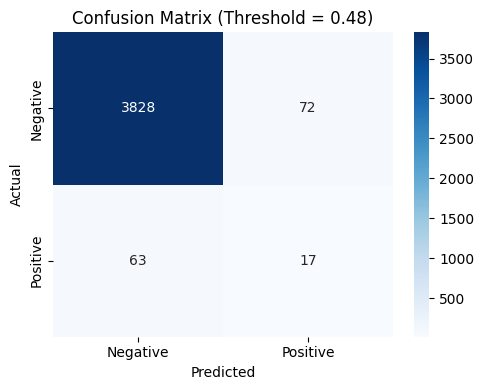

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# 1. 확률 예측
y_pred_prob = catboost_model.predict_proba(X_test)[:, 1]

# 2. 다양한 threshold에서 F1 score 계산
thresholds = np.linspace(0.1, 0.9, 50)
f1s = []

for t in thresholds:
    preds = (y_pred_prob >= t).astype(int)
    f1s.append(f1_score(y_test, preds))

# 3. 최적 threshold
best_threshold = thresholds[np.argmax(f1s)]
best_f1 = max(f1s)

# 4. 최적 threshold로 예측
y_pred_best = (y_pred_prob >= best_threshold).astype(int)

# 5. 성능 출력
print(f"✅ 최적 Threshold: {best_threshold:.2f}")
print(f"✅ F1 Score (최적 threshold): {best_f1:.4f}")
print("✅ Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

# 6. Confusion Matrix 시각화
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {best_threshold:.2f})")
plt.tight_layout()
plt.show()

Feature importance

/tmp/ipykernel_28/273896562.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[sorted_idx[:10]], y=np.array(feature_names)[sorted_idx[:10]], palette="viridis")


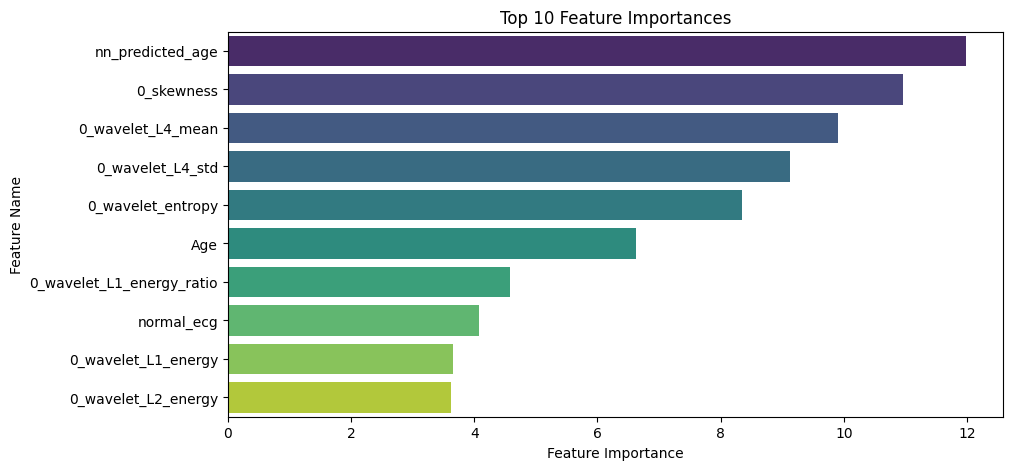

In [25]:
# feature importance
feature_names = df.drop(columns=["Chagas_label"]).columns.tolist()
plot_feature_importance(catboost_model, feature_names)

In [26]:
# Challenge score

from helper_code import compute_challenge_score  # helper_code에서 함수 가져오기

# 모델 예측값 (확률 기반)
y_pred_prob = catboost_model.predict_proba(X_test)[:, 1]  # 모델이 1(양성)일 확률 예측

# 실제 라벨
y_true = y_test  # 실제 정답 레이블 (0 또는 1)

# ✅ Challenge Score 계산
challenge_score = compute_challenge_score(y_true, y_pred_prob)

print(f"Challenge Score: {challenge_score:.3f}")


# Challenge Score: 0.390

Challenge Score: 0.312


상관계수 높은 피처 제거

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def remove_highly_correlated_features(df, threshold=0.9):
    """
    상관계수가 threshold 이상인 피처 중 하나를 제거.
    
    Parameters:
    - df: 입력 DataFrame (수치형 피처만 포함해야 함)
    - threshold: 상관계수 기준 (default: 0.9)
    
    Returns:
    - 제거된 컬럼 목록
    - 제거 후 DataFrame
    """
    # 상관계수 행렬
    corr_matrix = df.corr().abs()

    # 상삼각행렬만 사용 (중복 제거)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # 상관계수가 threshold보다 큰 컬럼 쌍에서 하나씩 제거
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    print(f"🔻 상관계수 {threshold} 초과로 제거된 피처 수: {len(to_drop)}")
    return to_drop, df.drop(columns=to_drop)


def plot_correlation_heatmap(df, figsize=(16, 12), threshold=0.9):
    """
    상관계수 히트맵 시각화 함수
    
    Parameters:
    - df: 수치형 피처만 포함된 DataFrame
    - figsize: 플롯 크기 설정
    - threshold: 상관계수 기준선 (선택적으로 표시)
    """
    corr = df.corr()

    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=False, cmap='coolwarm', center=0, fmt=".2f",
                cbar_kws={"shrink": 0.8}, square=True)
    plt.title("📊 Feature Correlation Heatmap", fontsize=16)
    plt.tight_layout()
    plt.show()

    # 강한 상관 피처 쌍 출력
    high_corr_pairs = []
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > threshold:
                pair = (corr.columns[i], corr.columns[j], corr.iloc[i, j])
                high_corr_pairs.append(pair)

    if high_corr_pairs:
        print(f"\n🔎 상관계수 {threshold} 초과 피처쌍:")
        for feat1, feat2, corr_val in sorted(high_corr_pairs, key=lambda x: -abs(x[2])):
            print(f"  {feat1} ↔ {feat2} : {corr_val:.2f}")
    else:
        print(f"\n✅ 상관계수 {threshold} 초과 피처쌍 없음.")


/tmp/ipykernel_30/595258678.py:47: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


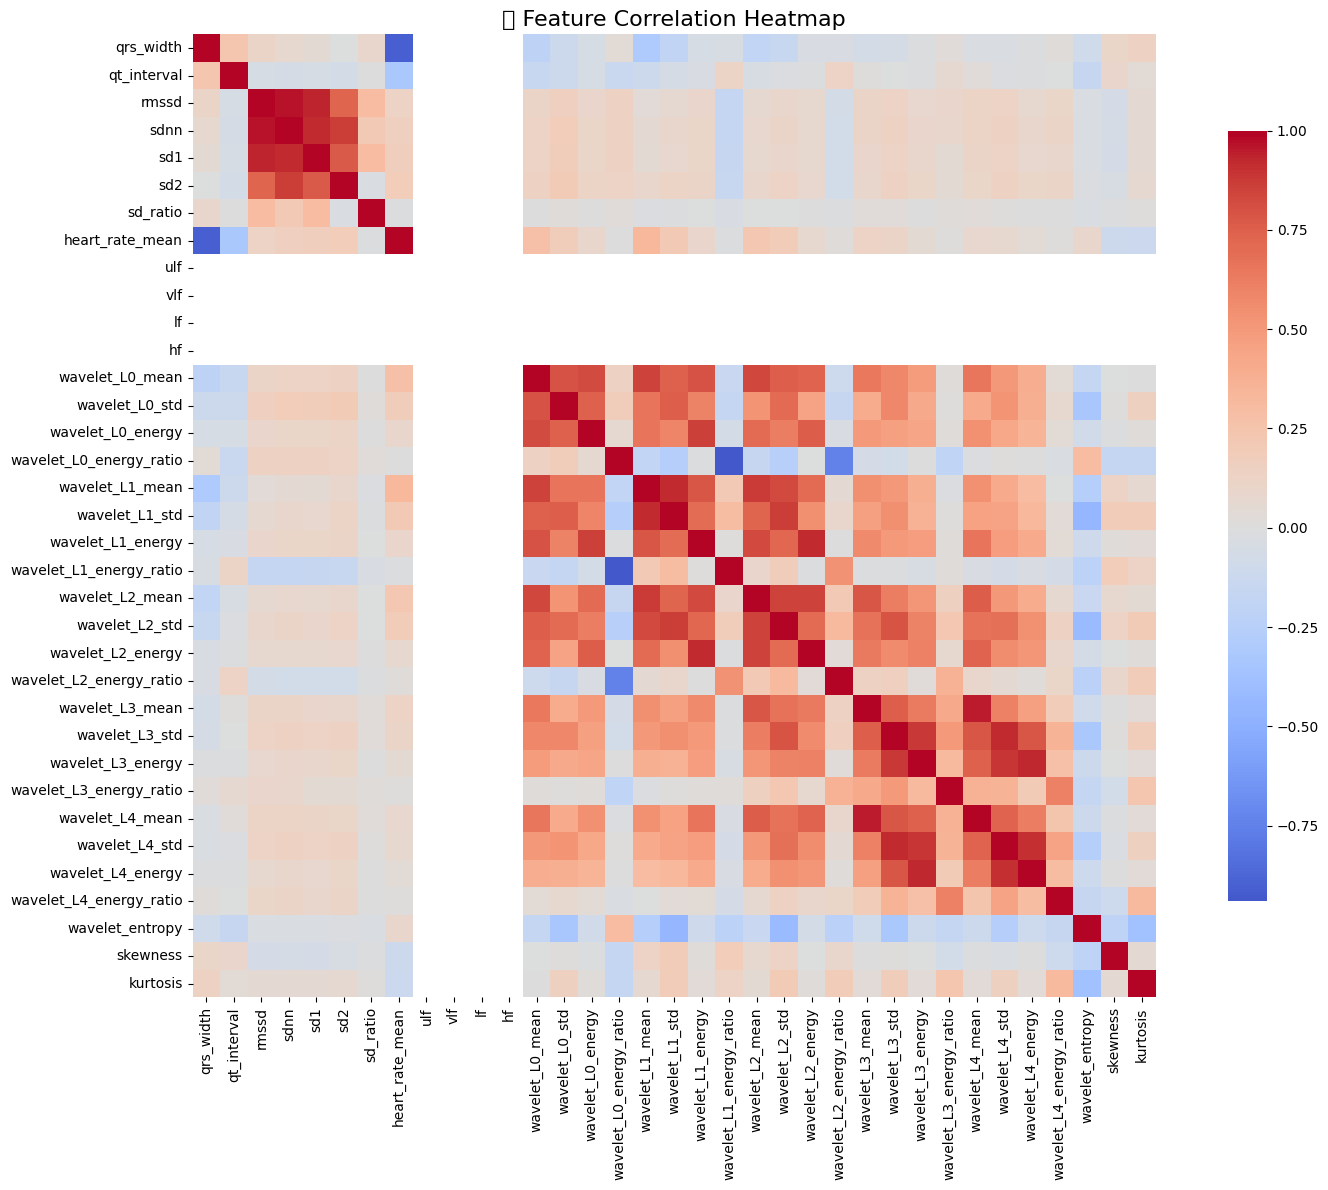


🔎 상관계수 0.9 초과 피처쌍:
  sdnn ↔ rmssd : 0.97
  wavelet_L4_mean ↔ wavelet_L3_mean : 0.95
  wavelet_L1_energy_ratio ↔ wavelet_L0_energy_ratio : -0.94
  sd1 ↔ rmssd : 0.94
  wavelet_L4_energy ↔ wavelet_L3_energy : 0.93
  wavelet_L1_std ↔ wavelet_L1_mean : 0.92
  wavelet_L4_std ↔ wavelet_L3_std : 0.92
  wavelet_L2_energy ↔ wavelet_L1_energy : 0.92
  sd1 ↔ sdnn : 0.92
  wavelet_L4_energy ↔ wavelet_L4_std : 0.91
  heart_rate_mean ↔ qrs_width : -0.91
🔻 상관계수 0.9 초과로 제거된 피처 수: 9


In [55]:
# X_numeric_scaled는 ndarray이므로 DataFrame으로 변환
X_numeric_df = pd.DataFrame(X_numeric_scaled, columns=X_numeric.columns)
plot_correlation_heatmap(X_numeric_df)

# 상관계수 기반 제거
dropped_cols, X_numeric_reduced = remove_highly_correlated_features(X_numeric_df)

# 다시 결합
X = np.hstack([X_numeric_reduced.values, X_categorical])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # 클래스 불균형 고려
)

In [56]:
study_cat = optuna.create_study(direction="maximize")
study_cat.optimize(objective_catboost, n_trials=10)

best_params_cat = study_cat.best_params
print("최적 CatBoost 하이퍼파라미터:", best_params_cat)

[I 2025-03-27 15:36:11,763] A new study created in memory with name: no-name-70706c89-1694-4de8-9aa1-f0019eb2a57a
/tmp/ipykernel_30/1075999890.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_30/1075999890.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
/tmp/ipykernel_30/1075999890.py:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_u

최적 CatBoost 하이퍼파라미터: {'n_estimators': 839, 'depth': 5, 'learning_rate': 0.12358475702840321, 'l2_leaf_reg': 0.026933434778883915, 'bagging_temperature': 0.981304905613334}


In [62]:
catboost_model = CatBoostClassifier(
                    **best_params_cat,
                    class_weights = [1, 10],
                    verbose=0)
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)

# ✅ 3. CatBoost 모델 평가
y_pred_cat = catboost_model.predict(X_test)
accuracy_cat = accuracy_score(y_test, y_pred_cat)
f1_cat = f1_score(y_test, y_pred_cat)

print(f"CatBoost Accuracy: {accuracy_cat:.4f}")
print(f"CatBoost F1 Score: {f1_cat:.4f}")

# 별로 유의미하진 않았다 ,,
# CatBoost Accuracy: 0.9719
# CatBoost F1 Score: 0.0968


CatBoost Accuracy: 0.9719
CatBoost F1 Score: 0.0968


## 모델링 2 > CNN

In [49]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 예시 DataFrame 구조 시뮬레이션
# df에는 'p_signal'이라는 열이 있고, 여기에 (samples, leads) 형태의 numpy array가 있음
# 예: df.iloc[0]['p_signal'].shape = (4096, 12)

# 아래는 실제 데이터를 사용할 때 실행 가능한 구조입니다.

def append_signal_features(df, fs=400, lead_index=0, column_name='processed_signal'):
    """
    df에서 선택한 리드만 뽑아 전처리한 후, 새로운 컬럼으로 추가함.
    
    Parameters:
        df (pd.DataFrame): p_signal 컬럼이 포함된 원본 데이터프레임
        fs (int): 샘플링 주파수
        lead_index (int): 사용할 리드 인덱스
        column_name (str): 추가할 컬럼명
    
    Returns:
        pd.DataFrame: 전처리된 신호가 추가된 데이터프레임
    """
    from scipy.signal import butter, filtfilt
    import pywt
    import scipy.ndimage

    processed_signals = []
    for _, row in df.iterrows():
        signal = row['p_signal'][:, lead_index]
        processed = preprocess_ecg(signal)
        processed_signals.append(processed)

    df[column_name] = processed_signals
    return df

df = append_signal_features(df_part0)

/opt/conda/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pywt/_thresholding.py:22: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)


In [51]:
df.head()

,exam_id,p_signal,Age,Chagas_label,is_male,nn_predicted_age,RBBB,LBBB,AF,normal_ecg,processed_signal
0,1398216,"[[-1.601, 1.052, 2.652, 0.274, -2.127, 1.852, ...",35,0,0,50.454483,0,0,0,0,"[0.37955694292501285, 0.35929212733638505, 0.3..."
1,620215,"[[0.518, 1.326, 0.808, -0.922, -0.145, 1.067, ...",19,0,0,28.217638,0,0,0,1,"[0.0002714564730235519, 0.00018894121298737338..."
2,712938,"[[1.837, 1.573, -0.264, -1.7, 1.055, 0.655, -1...",59,0,0,67.447525,0,0,0,0,"[1.6116500007338277, 1.2722895370536875, 0.974..."
3,1504935,"[[-1.951, -4.063, -2.111, 3.011, 0.084, -3.087...",60,0,0,64.676575,0,0,0,1,"[0.020984094904746262, 0.020051887560491262, 0..."
4,1229800,"[[0.195, -0.205, -0.401, 0.01, 0.303, -0.303, ...",58,0,0,66.523140,0,0,0,0,"[0.2621720955106708, 0.20739520393993122, 0.16..."


In [56]:
# 위아래로 이어 붙이기 (row 방향 concat)
df = pd.concat([df0, df['processed_signal']], axis=1)

df.head()

,0_qrs_width,0_qt_interval,0_rmssd,0_sdnn,0_sd1,0_sd2,0_sd_ratio,0_heart_rate_mean,0_ulf,0_vlf,...,Age,Chagas_label,is_male,nn_predicted_age,RBBB,LBBB,AF,normal_ecg,Age_gap,processed_signal
0,0.719167,0.460192,0.039765,0.023965,0.028096,0.020663,1.359698,83.520850,0.0,0.0,...,35.0,0.0,0.0,50.454483,0.0,0.0,0.0,0.0,-15.454483,"[0.37955694292501285, 0.35929212733638505, 0.3..."
1,1.089286,0.468750,0.183283,0.115463,0.128349,0.110663,1.159816,55.712566,0.0,0.0,...,19.0,0.0,0.0,28.217638,0.0,0.0,0.0,1.0,-9.217638,"[0.0002714564730235519, 0.00018894121298737338..."
2,0.650000,0.465000,0.008073,0.007071,0.005428,0.005901,0.919866,92.318824,0.0,0.0,...,59.0,0.0,0.0,67.447525,0.0,0.0,0.0,0.0,-8.447525,"[1.6116500007338277, 1.2722895370536875, 0.974..."
3,0.936944,0.454750,0.022896,0.022135,0.016152,0.028661,0.563561,64.073928,0.0,0.0,...,60.0,0.0,0.0,64.676575,0.0,0.0,0.0,1.0,-4.676575,"[0.020984094904746262, 0.020051887560491262, 0..."
4,0.767813,0.464167,0.023414,0.027141,0.015199,0.029436,0.516331,78.238343,0.0,0.0,...,58.0,0.0,0.0,66.523140,0.0,0.0,0.0,0.0,-8.523140,"[0.2621720955106708, 0.20739520393993122, 0.16..."


In [60]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np

In [67]:
# 'Chagas_label' 결측값이 없는 행만 필터링
df = df.dropna(subset=['Chagas_label', 'processed_signal'])

X_tabular = df.drop(columns=['Chagas_label', 'processed_signal']).values
y_label = df['Chagas_label'].values

# 모든 processed_signal의 길이 확인
signal_lengths = [len(s) for s in df['processed_signal']]
max_len = max(signal_lengths)  # 또는 원하는 길이 설정 가능

# Zero-padding (뒤에 0 추가)
X_signal_padded = pad_sequences(df['processed_signal'], maxlen=max_len, dtype='float32', padding='post', truncating='post')
X_signal = np.array(X_signal_padded)


# 정규화
scaler = StandardScaler()
X_tabular = scaler.fit_transform(X_tabular)

# Train/Test Split
X_tab_train, X_tab_test, X_sig_train, X_sig_test, y_train, y_test = train_test_split(
    X_tabular, X_signal, y_label, test_size=0.2, stratify=y_label, random_state=42)

In [69]:
# 모델 정의 (tabular에는 mlp, 신호에는 1dcnn 적용)
from tensorflow.keras.losses import BinaryFocalCrossentropy  # 상단 import 필요

# Branch 1: Tabular (MLP)
tabular_input = Input(shape=(X_tabular.shape[1],), name='tabular_input')
x1 = Dense(64, activation='relu')(tabular_input)
x1 = Dropout(0.3)(x1)
x1 = Dense(32, activation='relu')(x1)

# Branch 2: 1D CNN on ECG signal
signal_input = Input(shape=(X_signal.shape[1], 1), name='signal_input')
x2 = Conv1D(32, kernel_size=5, activation='relu')(signal_input)
x2 = Conv1D(64, kernel_size=5, activation='relu')(x2)
x2 = GlobalAveragePooling1D()(x2)

# Concatenate
combined = Concatenate()([x1, x2])
x = Dense(64, activation='relu')(combined)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[tabular_input, signal_input], outputs=output)
model.compile(
    optimizer='adam',
    loss=BinaryFocalCrossentropy(gamma=2.0, alpha=0.25),  # facal loss
    metrics=['accuracy']
)

# Training
model.fit(
    [X_tab_train, X_sig_train[..., np.newaxis]], y_train,
    validation_data=([X_tab_test, X_sig_test[..., np.newaxis]], y_test),
    epochs=10,
    batch_size=64,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# Evaluation
preds = model.predict([X_tab_test, X_sig_test[..., np.newaxis]])

Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9545 - loss: 0.1535 - val_accuracy: 0.9799 - val_loss: 0.1167
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9815 - loss: 0.1069 - val_accuracy: 0.9799 - val_loss: 0.0835
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.9799 - loss: 0.0778 - val_accuracy: 0.9799 - val_loss: 0.0635
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9802 - loss: 0.0598 - val_accuracy: 0.9799 - val_loss: 0.0511
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.9807 - loss: 0.0485 - val_accuracy: 0.9799 - val_loss: 0.0433
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9804 - loss: 0.0417 - val_accuracy: 0.9799 - val_loss: 0.0384
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9790 - loss: 0.0380 - val_accuracy: 0.9799 - val_loss: 0.0351
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9789 - loss: 0.0352 - 

In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# 확률 → 이진 예측값 (0 or 1)
y_pred_binary = (preds > 0.5).astype(int)

# 지표 계산
print("🔹 Accuracy:", accuracy_score(y_test, y_pred_binary))
print("🔹 Precision:", precision_score(y_test, y_pred_binary))
print("🔹 Recall:", recall_score(y_test, y_pred_binary))   # = Sensitivity
print("🔹 F1-score:", f1_score(y_test, y_pred_binary))
print("🔹 ROC-AUC:", roc_auc_score(y_test, preds))

# 혼동 행렬
print("🔹 Confusion Matrix:\n", confusion_matrix(y_test, y_pred_binary))

🔹 Accuracy: 0.9798994974874372
🔹 Precision: 0.0
🔹 Recall: 0.0
🔹 F1-score: 0.0
🔹 ROC-AUC: 0.5
🔹 Confusion Matrix:
 [[3900    0]
 [  80    0]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [71]:
from helper_code import compute_challenge_score

# y_test: ground-truth label 배열
# preds: 모델에서 나온 확률 예측값

challenge_score = compute_challenge_score(y_test, preds)
print(f"Challenge Score (TPR@5%): {challenge_score:.4f}")

Challenge Score (TPR@5%): 0.0000


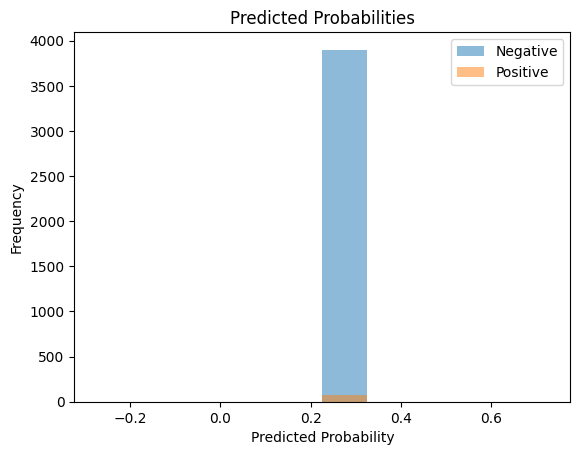

In [80]:
import matplotlib.pyplot as plt

plt.hist(preds[y_test == 0], bins=10, alpha=0.5, label='Negative')
plt.hist(preds[y_test == 1], bins=10, alpha=0.5, label='Positive')
plt.title('Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## 모델 3 > catboost + 1dcnn

In [83]:
from catboost import CatBoostClassifier

# ✅ 모델 정의
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    class_weights=[1, 20],  # 클래스 불균형 보정
    verbose=0
)

catboost_model.fit(X_tab_train, y_train)
catboost_preds = catboost_model.predict_proba(X_tab_test)[:, 1]

In [73]:
# reshape
X_sig_train = X_sig_train[..., np.newaxis]
X_sig_test = X_sig_test[..., np.newaxis]

signal_input = Input(shape=(X_sig_train.shape[1], 1), name='signal_input')
x = Conv1D(32, kernel_size=5, activation='relu')(signal_input)
x = Conv1D(64, kernel_size=5, activation='relu')(x)
x = GlobalAveragePooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

cnn_model = Model(inputs=signal_input, outputs=output)
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_model.fit(
    X_sig_train, y_train,
    validation_data=(X_sig_test, y_test),
    epochs=20,
    batch_size=64,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

cnn_preds = cnn_model.predict(X_sig_test).ravel()

Epoch 1/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9525 - loss: 0.3384 - val_accuracy: 0.9799 - val_loss: 0.6087
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9806 - loss: 0.5765 - val_accuracy: 0.9799 - val_loss: 0.4960
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9829 - loss: 0.4731 - val_accuracy: 0.9799 - val_loss: 0.4170
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9799 - loss: 0.4008 - val_accuracy: 0.9799 - val_loss: 0.3563
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9789 - loss: 0.3446 - val_accuracy: 0.9799 - val_loss: 0.3085
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.9800 - loss: 0.2982 - val_accuracy: 0.9799 - val_loss: 0.2704
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9790 - loss: 0.2634 - val_accuracy: 0.9799 - val_loss: 0.2397
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.9812 - loss: 0.2312 - va

In [93]:

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow as tf

# ✅ 차원 확인 후 잘못된 차원 정리
X_sig_train = np.array(X_sig_train)
X_sig_test = np.array(X_sig_test)

# ✅ 필요하면 squeeze
X_sig_train = np.squeeze(X_sig_train)
X_sig_test = np.squeeze(X_sig_test)

# ✅ 정확한 3D shape으로 reshape: (batch_size, length, 1)
X_sig_train = X_sig_train.reshape((X_sig_train.shape[0], X_sig_train.shape[1], 1))
X_sig_test = X_sig_test.reshape((X_sig_test.shape[0], X_sig_test.shape[1], 1))


# === 클래스 불균형 처리: class_weight 계산 ===
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# === 모델 정의 ===
signal_input = Input(shape=(X_sig_train.shape[1], 1), name='signal_input')
x = Conv1D(32, kernel_size=5, activation='relu')(signal_input)
x = Conv1D(64, kernel_size=5, activation='relu')(x)
x = GlobalAveragePooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

cnn_model = Model(inputs=signal_input, outputs=output)

cnn_model.compile(
    optimizer='adam',
    loss=BinaryFocalCrossentropy(gamma=2.0),  # focal loss 적용
    metrics=['accuracy']
)

# === 모델 학습 ===
cnn_model.fit(
    X_sig_train, y_train,
    validation_data=(X_sig_test, y_test),
    epochs=10,
    batch_size=64,
    class_weight=class_weight_dict,  # class weight 적용
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# === 예측 및 평가 ===
cnn_preds = cnn_model.predict(X_sig_test).ravel()
predicted_labels = (cnn_preds > 0.5).astype(int)

report = classification_report(y_test, predicted_labels, digits=4)
conf_matrix = confusion_matrix(y_test, predicted_labels)
roc_auc = roc_auc_score(y_test, cnn_preds)

(report, conf_matrix, roc_auc)

Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7250 - loss: 0.1686 - val_accuracy: 0.0201 - val_loss: 0.1743
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.1207 - loss: 0.1761 - val_accuracy: 0.9799 - val_loss: 0.1728
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.5717 - loss: 0.1723 - val_accuracy: 0.0201 - val_loss: 0.1738
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.4268 - loss: 0.1709 - val_accuracy: 0.9799 - val_loss: 0.1732
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.6450 - loss: 0.1633 - val_accuracy: 0.9799 - val_loss: 0.1730
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.1815 - loss: 0.1693 - val_accuracy: 0.0201 - val_loss: 0.1750
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.6533 - loss: 0.1646 - val_accuracy: 0.0201 - val_loss: 0.1748
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step  


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


('              precision    recall  f1-score   support\n\n         0.0     0.9799    1.0000    0.9898      3900\n         1.0     0.0000    0.0000    0.0000        80\n\n    accuracy                         0.9799      3980\n   macro avg     0.4899    0.5000    0.4949      3980\nweighted avg     0.9602    0.9799    0.9700      3980\n',
 array([[3900,    0],
        [  80,    0]]),
 0.5)

In [94]:
# 단순 평균 앙상블
ensemble_preds = (catboost_preds + cnn_preds) / 2

In [96]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

def evaluate(y_true, y_pred_probs, name='Model'):
    y_pred_labels = (y_pred_probs >= 0.5).astype(int)
    print(f"\n📊 [{name}]")
    print(f"Accuracy     : {accuracy_score(y_true, y_pred_labels):.4f}")
    print(f"Precision    : {precision_score(y_true, y_pred_labels, zero_division=0):.4f}")
    print(f"Recall       : {recall_score(y_true, y_pred_labels):.4f}")
    print(f"F1-Score     : {f1_score(y_true, y_pred_labels, zero_division=0):.4f}")
    print(f"ROC AUC      : {roc_auc_score(y_true, y_pred_probs):.4f}")
    print(f"Confusion    :\n{confusion_matrix(y_true, y_pred_labels)}")


evaluate(y_test, catboost_preds, name="CatBoost")
evaluate(y_test, cnn_preds, name="1D CNN")
evaluate(y_test, ensemble_preds, name="CatBoost + CNN Ensemble")



📊 [CatBoost]
Accuracy     : 0.9754
Precision    : 0.2500
Recall       : 0.1125
F1-Score     : 0.1552
ROC AUC      : 0.7553
Confusion    :
[[3873   27]
 [  71    9]]

📊 [1D CNN]
Accuracy     : 0.9799
Precision    : 0.0000
Recall       : 0.0000
F1-Score     : 0.0000
ROC AUC      : 0.5000
Confusion    :
[[3900    0]
 [  80    0]]

📊 [CatBoost + CNN Ensemble]
Accuracy     : 0.9754
Precision    : 0.2500
Recall       : 0.1125
F1-Score     : 0.1552
ROC AUC      : 0.7553
Confusion    :
[[3873   27]
 [  71    9]]


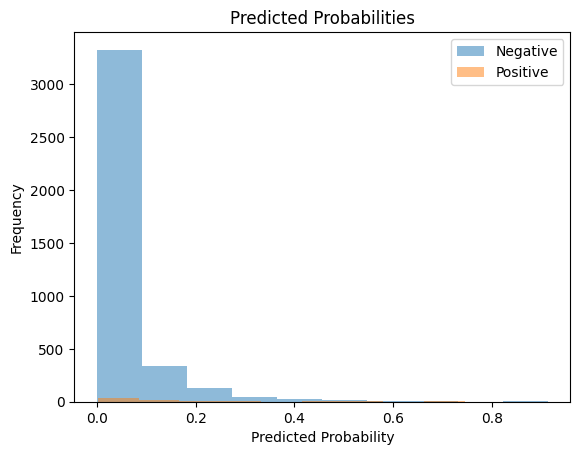

In [97]:
import matplotlib.pyplot as plt

plt.hist(catboost_preds[y_test == 0], bins=10, alpha=0.5, label='Negative')
plt.hist(catboost_preds[y_test == 1], bins=10, alpha=0.5, label='Positive')
plt.title('Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [101]:
from helper_code import compute_challenge_score

# y_test: ground-truth label 배열
# preds: 모델에서 나온 확률 예측값

challenge_score = compute_challenge_score(y_test, ensemble_preds)
print(f"Challenge Score (TPR@5%): {challenge_score:.4f}")

Challenge Score (TPR@5%): 0.2375


In [106]:
from sklearn.linear_model import LogisticRegression

stacked_input = np.vstack([catboost_preds, cnn_preds]).T  # (n_samples, 2)
meta_model = CatBoostClassifier()
meta_model.fit(stacked_input, y_test) 
ensemble_preds = meta_model.predict_proba(stacked_input)[:, 1]

Learning rate set to 0.018582
0:	learn: 0.6552469	total: 6.42ms	remaining: 6.42s
1:	learn: 0.6206856	total: 12ms	remaining: 6.01s
2:	learn: 0.5881766	total: 17.6ms	remaining: 5.83s
3:	learn: 0.5564643	total: 22.6ms	remaining: 5.63s
4:	learn: 0.5275163	total: 27.9ms	remaining: 5.55s
5:	learn: 0.5000518	total: 32.5ms	remaining: 5.38s
6:	learn: 0.4739289	total: 36.5ms	remaining: 5.17s
7:	learn: 0.4502976	total: 39.2ms	remaining: 4.86s
8:	learn: 0.4276194	total: 42.9ms	remaining: 4.72s
9:	learn: 0.4065430	total: 46ms	remaining: 4.56s
10:	learn: 0.3873132	total: 48.3ms	remaining: 4.34s
11:	learn: 0.3691539	total: 51.5ms	remaining: 4.24s
12:	learn: 0.3521006	total: 54.3ms	remaining: 4.12s
13:	learn: 0.3363144	total: 57ms	remaining: 4.01s
14:	learn: 0.3214182	total: 59.7ms	remaining: 3.92s
15:	learn: 0.3074452	total: 62.2ms	remaining: 3.83s
16:	learn: 0.2945843	total: 64.7ms	remaining: 3.74s
17:	learn: 0.2821917	total: 67.1ms	remaining: 3.66s
18:	learn: 0.2713576	total: 68.9ms	remaining: 3.56

In [107]:
evaluate(y_test, ensemble_preds, name="CatBoost + CNN Ensemble + logistic")


📊 [CatBoost + CNN Ensemble + logistic]
Accuracy     : 0.9799
Precision    : 0.0000
Recall       : 0.0000
F1-Score     : 0.0000
ROC AUC      : 0.8985
Confusion    :
[[3900    0]
 [  80    0]]


In [109]:
catboost_labels = (catboost_preds > 0.5).astype(int)
cnn_labels = (cnn_preds > 0.5).astype(int)

# 다수결 (0 또는 1)
ensemble_labels = (catboost_labels + cnn_labels >= 1).astype(int)
evaluate(y_test, ensemble_labels, name="CatBoost + CNN Ensemble > voting")


📊 [CatBoost + CNN Ensemble > voting]
Accuracy     : 0.9754
Precision    : 0.2500
Recall       : 0.1125
F1-Score     : 0.1552
ROC AUC      : 0.5528
Confusion    :
[[3873   27]
 [  71    9]]
